In [169]:
import sys
import os
import pandas as pd
import numpy as np
import warnings
import pandas_ta as ta
from datetime import datetime
warnings.filterwarnings("ignore")

from typing import Optional, Union
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})
sys.path.insert(0, 'C:/Users/vitil/OneDrive/Desktop/btc_project')

## Config features 

In [ ]:
D_DEFAULT=0.72
MAX_WEIGHTS=25

## Download data

In [171]:
source_file = 'BTCUSDT_1h_inf.csv'
df = pd.read_csv(f"C:/Users/vitil/OneDrive/Desktop/btc_project/data/{source_file}")
df_features = df.copy()
df['ds'] = pd.to_datetime(df['ds'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13273 entries, 0 to 13272
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      13273 non-null  datetime64[ns]
 1   y       13273 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 207.5 KB


In [172]:
df.head()

,ds,y
0,2024-01-01 00:00:00,42475.23
1,2024-01-01 01:00:00,42613.56
2,2024-01-01 02:00:00,42581.10
3,2024-01-01 03:00:00,42330.49
4,2024-01-01 04:00:00,42399.99


## 2. Fractional differentiation

In [ ]:
from utils.fracdiff import fast_fracdiff, get_weights_ffd, frac_diff, get_weights

for d in np.arange(D_DEFAULT, 1.0, .1):
    d = np.round(d, 2)
    result = frac_diff(df.y.values, d=d, max_weight_len=MAX_WEIGHTS)
    df.loc[df.index[len(df) - len(result):], f'y_d{d}'] = result.values

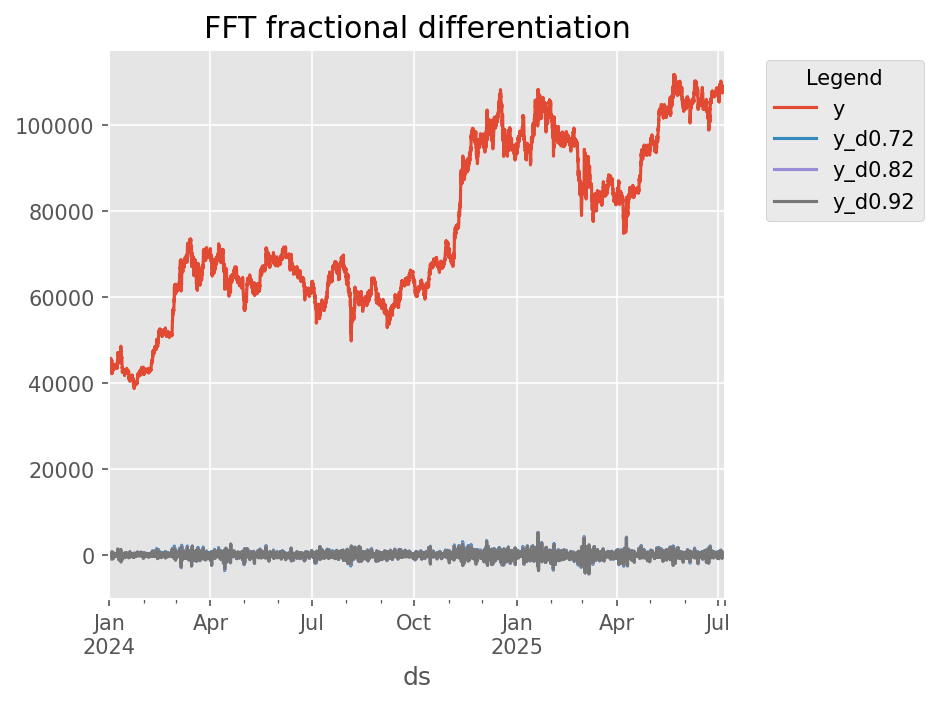

In [174]:
ax = df.plot(x='ds', title="FFT fractional differentiation")
plt.legend(title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

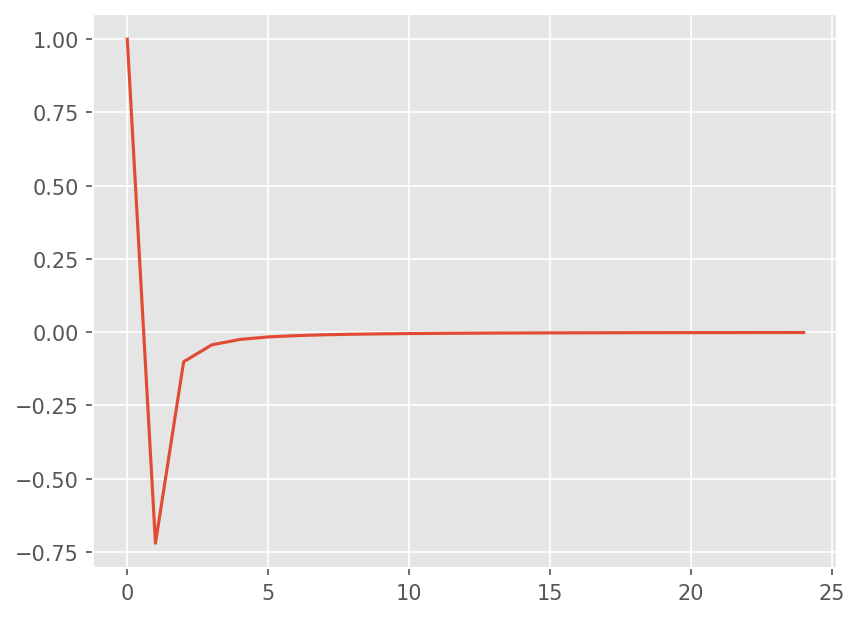

In [ ]:
w = get_weights(D_DEFAULT, size=MAX_WEIGHTS)
plt.plot(w[::-1])
plt.show()

In [176]:
w

array([[-9.71263087e-04],
       [-1.04624390e-03],
       [-1.13080873e-03],
       [-1.22671558e-03],
       [-1.33615286e-03],
       [-1.46187403e-03],
       [-1.60738464e-03],
       [-1.77720660e-03],
       [-1.97725866e-03],
       [-2.21541586e-03],
       [-2.50235225e-03],
       [-2.85284459e-03],
       [-3.28785281e-03],
       [-3.83796047e-03],
       [-4.54930660e-03],
       [-5.49433164e-03],
       [-6.79244296e-03],
       [-8.65279358e-03],
       [-1.14715066e-02],
       [-1.60815514e-02],
       [-2.45145600e-02],
       [-4.30080000e-02],
       [-1.00800000e-01],
       [-7.20000000e-01],
       [ 1.00000000e+00]])

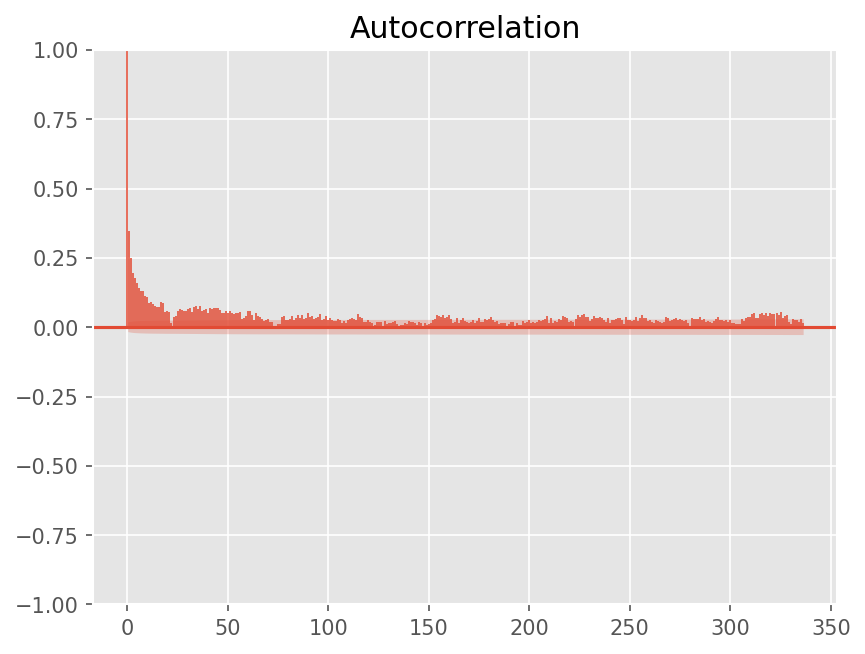

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(
    frac_diff(df.y.values, d=D_DEFAULT, max_weight_len=MAX_WEIGHTS),
    lags=24*14,
    vlines_kwargs={'linewidth': 0.75},
    marker='None' 
)
plt.show()

## 5. Entropy based weighting


In [178]:
from typing import Optional, Callable, Dict
from antropy import perm_entropy

def permutation_entropy_sample_weights(
    y: pd.Series,
    window_len: int,
    embedding_dim: int,
    quantiles: np.array = np.arange(0.1, 1, 0.1),
    weight_function: Optional[Callable] = None
) -> Dict[str, pd.Series]:
    """
    Fast implementation using numpy vectorization where possible.
    """
    
    # Compute rolling permutation entropy
    perm_entropies = y.rolling(
        window=window_len, 
        min_periods=window_len
    ).apply(
        lambda x: perm_entropy(x.values, order=embedding_dim, normalize=True) 
        if len(x.dropna()) >= embedding_dim + 1 else np.nan,
        raw=False
    )
    
    # Get valid entropies for quantile calculation
    valid_entropies = perm_entropies.dropna()
    
    if len(valid_entropies) == 0:
        raise ValueError("No valid entropy values computed")
    
    # Compute quantile thresholds
    quantile_thresholds = valid_entropies.quantile(quantiles).values
    
    # Vectorized quantile assignment using searchsorted
    quantile_indices = pd.Series(index=y.index, dtype=float)
    valid_idx = valid_entropies.index
    
    # Use searchsorted for fast quantile assignment
    q_idx_values = np.searchsorted(quantile_thresholds, valid_entropies.values) + 1
    quantile_indices.loc[valid_idx] = q_idx_values
    
    # Define vectorized default weight function
    if weight_function is None:
        n_quantiles = len(quantiles) + 1
        alpha = 3.0
        
        # Vectorized weight calculation
        weights = pd.Series(index=y.index, dtype=float)
        valid_mask = ~quantile_indices.isna()
        
        if valid_mask.any():
            q_indices = quantile_indices[valid_mask].values
            normalized_idx = (q_indices - 1) / n_quantiles
            weights.loc[valid_mask] = np.exp(-alpha * normalized_idx)
    else:
        # Use provided weight function
        n_quantiles = len(quantiles) + 1
        weights = quantile_indices.apply(
            lambda q_idx: weight_function(q_idx, n_quantiles) if pd.notna(q_idx) else np.nan
        )

    
    return {
        'weights': weights,
        'permutation_entropies': perm_entropies
    }

In [179]:
def power_weight(q_idx, n_quantiles):
    """
    Inverse power law with steep decay.
    Low entropy (q_idx=1) → 9.5
    High entropy (q_idx=n_quantiles) → ~0.01
    """
    normalized_idx = (q_idx - 1) / (n_quantiles - 1)
    epsilon = 0.01 
    power = 1.3     
    scale = 0.95    
    
    weight = scale / ((normalized_idx + epsilon) ** power)
    return min(3.0, weight)  

In [ ]:
res = permutation_entropy_sample_weights(frac_diff(df.y.values, d = D_DEFAULT, max_weight_len=MAX_WEIGHTS), window_len = 24*5, weight_function=power_weight, embedding_dim = 3)

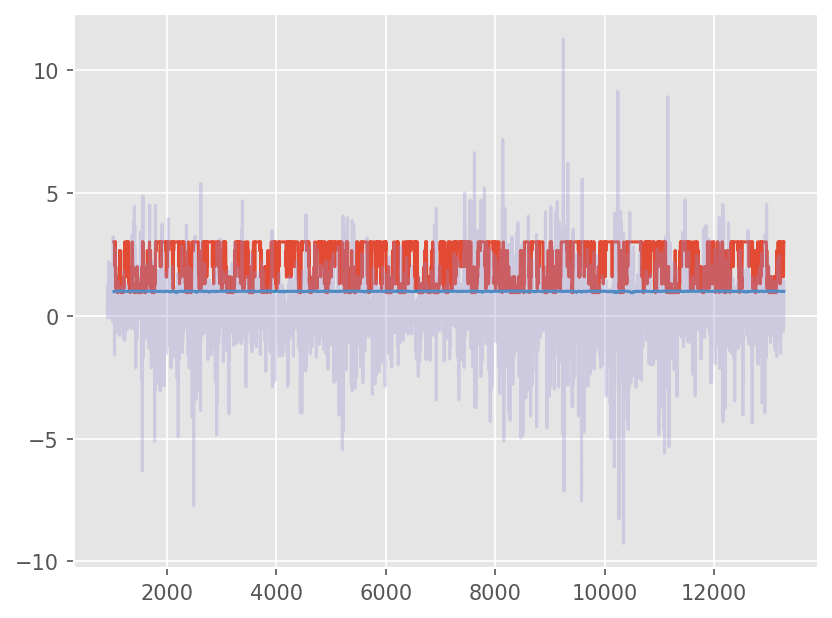

In [ ]:
plt.plot(res['weights'])
plt.plot(res['permutation_entropies'])
plt.plot(frac_diff(df.y.values, d = D_DEFAULT, max_weight_len=MAX_WEIGHTS)/frac_diff(df.y.values, d = D_DEFAULT, max_weight_len=MAX_WEIGHTS).std(), alpha = 0.3)
plt.show()

## Dataset to save

In [182]:
def apply_temporal_weights_exponential(df, date_column, decay_rate=0.01):
    """
    Apply exponential decay weights based on age of observations
    decay_rate: higher values = faster decay (more penalty for old data)
    """
    df[date_column] = pd.to_datetime(df[date_column])
    most_recent = df[date_column].max()
    days_old = (most_recent - df[date_column]).dt.days
    temporal_weights = np.exp(-decay_rate * days_old)
    
    return temporal_weights

In [183]:
temporal_weights = apply_temporal_weights_exponential(df_features, 'ds', decay_rate=0.005)

In [ ]:
import pandas_ta as ta

df_features['weights'] = res['weights']
df_features['temporal_weights'] = temporal_weights
df_features['combined_weights'] = df_features['temporal_weights'] #* res['weights']
max_weight = df_features['combined_weights'].max()
df_features['weights'] = df_features['combined_weights'] / max_weight
df_features.drop(columns=['combined_weights','temporal_weights'], inplace=True)

windows = [3, 6, 12, 24, 48, 120, 7*24, 14*24]  

rolling_means = {}
for window in windows:
    rolling_means[window] = df_features['y'].rolling(window=window).mean()
  

for i, short_window in enumerate(windows):
    for long_window in windows[i+1:]:
        ratio_col = f'y_mean_ratio_{short_window}_{long_window}_lag1'
        df_features[ratio_col] = (rolling_means[short_window] / rolling_means[long_window]).shift(1)


for d in np.arange(D_DEFAULT, 5.5, .1):
    d = np.round(d, 2)
    result = frac_diff(df_features.y.values, d=D_DEFAULT,max_weight_len=MAX_WEIGHTS)
    
    col_name = f'y_d{str(d).replace(".", "")}'
    df_features.loc[df_features.index[len(df_features) - len(result):], col_name] = result.values
    
    if d == 0.0:
        continue
    
    for lag in range(1, 24*2):
        lag_col_name = f'{col_name}_lag{lag}'
        df_features[lag_col_name] = df_features[col_name].shift(lag)


target_cols = ['y', f'y_d{str(D_DEFAULT).replace(".", "")}']

for col in target_cols:
    for window in windows:
        linreg_res = ta.linreg(df_features[col], length=window, angle=True)
        feat_name = f"{col}_linreg_slope_{window}_lag1"
        df_features[feat_name] = linreg_res.shift(1)

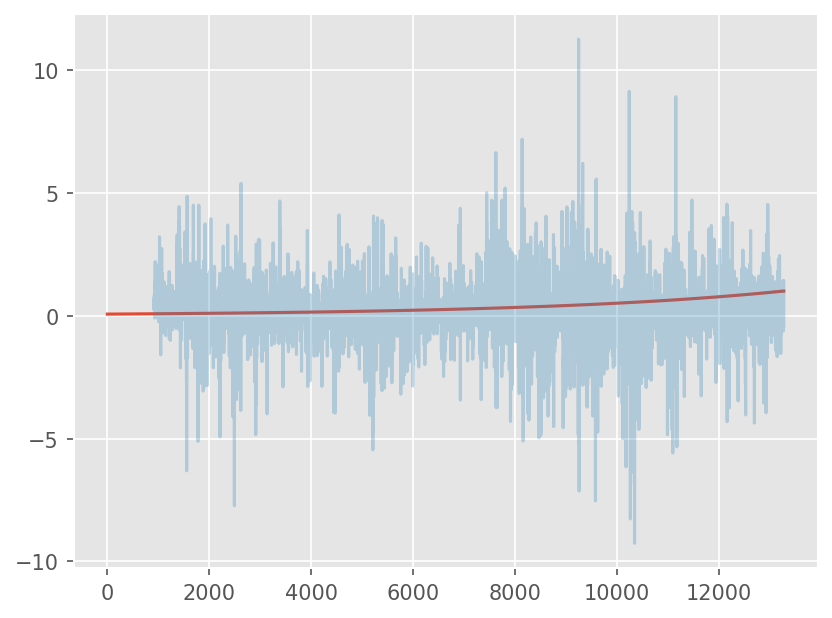

In [185]:
plt.plot(df_features['weights'])
plt.plot(frac_diff(df.y.values, d = D_DEFAULT, thres=THRESHOLD)/frac_diff(df.y.values, d = D_DEFAULT, thres=THRESHOLD).std(), alpha = 0.3)
plt.show()

In [186]:
df_features.dropna(inplace=True)
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12021 entries, 1252 to 13272
Columns: 2351 entries, ds to y_d072_linreg_slope_336_lag1
dtypes: datetime64[ns](1), float64(2350)
memory usage: 215.7 MB


In [187]:
df_features.head()

,ds,y,weights,y_mean_ratio_3_6_lag1,y_mean_ratio_3_12_lag1,y_mean_ratio_3_24_lag1,y_mean_ratio_3_48_lag1,y_mean_ratio_3_120_lag1,y_mean_ratio_3_168_lag1,y_mean_ratio_3_336_lag1,...,y_linreg_slope_168_lag1,y_linreg_slope_336_lag1,y_d072_linreg_slope_3_lag1,y_d072_linreg_slope_6_lag1,y_d072_linreg_slope_12_lag1,y_d072_linreg_slope_24_lag1,y_d072_linreg_slope_48_lag1,y_d072_linreg_slope_120_lag1,y_d072_linreg_slope_168_lag1,y_d072_linreg_slope_336_lag1
1252,2024-02-22 04:00:00,51434.61,0.082085,0.997898,1.002115,1.001298,0.995260,0.993646,0.992138,1.027521,...,-1.189776,1.521707,1.566534,-1.539585,1.497040,1.490393,-1.078311,-0.399852,-0.561815,-0.554165
1253,2024-02-22 05:00:00,51524.88,0.082085,0.999412,1.003243,1.002988,0.996666,0.994999,0.993478,1.028401,...,-1.191674,1.521167,-1.561291,-1.538437,1.502845,1.486940,-1.026641,-0.411554,-0.581754,-0.564520
1254,2024-02-22 06:00:00,51767.51,0.082085,1.001153,1.002968,1.003935,0.997508,0.995749,0.994212,1.028684,...,-1.196057,1.520630,-1.550441,1.552670,-0.646534,1.491061,-0.780357,-0.403479,-0.585987,-0.564183
1255,2024-02-22 07:00:00,51827.63,0.082085,1.001566,1.002662,1.005093,0.998751,0.996943,0.995403,1.029444,...,-1.192809,1.520097,1.565323,1.556280,-1.259918,1.503017,-0.013437,-0.303345,-0.539305,-0.561927
1256,2024-02-22 08:00:00,51888.52,0.082085,1.002200,1.003957,1.007434,1.001293,0.999489,0.997926,1.031611,...,-1.193496,1.519562,1.539059,1.513138,-0.061223,1.501564,0.221399,-0.250696,-0.541521,-0.560369


In [188]:
df_features.tail()

,ds,y,weights,y_mean_ratio_3_6_lag1,y_mean_ratio_3_12_lag1,y_mean_ratio_3_24_lag1,y_mean_ratio_3_48_lag1,y_mean_ratio_3_120_lag1,y_mean_ratio_3_168_lag1,y_mean_ratio_3_336_lag1,...,y_linreg_slope_168_lag1,y_linreg_slope_336_lag1,y_d072_linreg_slope_3_lag1,y_d072_linreg_slope_6_lag1,y_d072_linreg_slope_12_lag1,y_d072_linreg_slope_24_lag1,y_d072_linreg_slope_48_lag1,y_d072_linreg_slope_120_lag1,y_d072_linreg_slope_168_lag1,y_d072_linreg_slope_336_lag1
13268,2025-07-06 20:00:00,108665.47,1.0,0.998813,1.001645,1.003295,1.004224,1.002765,1.005668,1.014676,...,1.453675,1.498862,-1.554210,-1.559352,-1.294074,1.377997,0.494816,-1.114036,0.018836,-0.540942
13269,2025-07-06 21:00:00,109208.25,1.0,0.998445,1.000358,1.002295,1.003254,1.001773,1.004812,1.013629,...,1.453561,1.497187,1.566786,-1.518933,-1.447718,1.385001,0.773365,-1.089677,0.014703,-0.534529
13270,2025-07-06 22:00:00,109228.73,1.0,1.000264,1.001600,1.004154,1.005295,1.003798,1.007016,1.015662,...,1.455477,1.495469,1.567271,1.559039,-1.113578,1.472375,1.226693,-1.062945,0.156905,-0.539766
13271,2025-07-06 23:00:00,109203.84,1.0,1.001808,1.002765,1.005875,1.007233,1.005641,1.009082,1.017577,...,1.458785,1.494224,1.544698,1.560221,-1.337709,1.485883,1.329451,-1.082160,0.300571,-0.477703
13272,2025-07-07 00:00:00,108823.07,1.0,1.003020,1.003548,1.007141,1.008654,1.007024,1.010696,1.019019,...,1.462510,1.492909,-1.566619,1.560510,-1.479870,1.485029,1.304402,-1.091635,0.394455,-0.470993


In [189]:
from scipy import stats

# Rename target column
target_name = f'y_d{str(D_DEFAULT).replace(".", "")}'
df_features = df_features.rename(columns={target_name: 'target'})

# Define rolling windows
windows = [3, 6, 12, 24, 48, 5*24, 7*24, 14*24, 30*24]

# Compute rolling window features for target
for window in windows:
    # Mean
    df_features[f'target_mean_w{window}'] = df_features['target'].rolling(window=window, min_periods=1).mean()
    
    # Standard deviation
    df_features[f'target_std_w{window}'] = df_features['target'].rolling(window=window, min_periods=1).std()
    
    # Skewness
    df_features[f'target_skew_w{window}'] = df_features['target'].rolling(window=window, min_periods=3).apply(lambda x: stats.skew(x), raw=True)
    
    # Kurtosis
    df_features[f'target_kurt_w{window}'] = df_features['target'].rolling(window=window, min_periods=3).apply(lambda x: stats.kurtosis(x), raw=True)
    
    # Quantiles
    df_features[f'target_min_w{window}'] = df_features['target'].rolling(window=window, min_periods=1).min()
    df_features[f'target_q10_w{window}'] = df_features['target'].rolling(window=window, min_periods=1).quantile(0.1)
    df_features[f'target_q25_w{window}'] = df_features['target'].rolling(window=window, min_periods=1).quantile(0.25)
    df_features[f'target_q50_w{window}'] = df_features['target'].rolling(window=window, min_periods=1).quantile(0.5)
    df_features[f'target_q75_w{window}'] = df_features['target'].rolling(window=window, min_periods=1).quantile(0.75)
    df_features[f'target_q90_w{window}'] = df_features['target'].rolling(window=window, min_periods=1).quantile(0.9)
    df_features[f'target_max_w{window}'] = df_features['target'].rolling(window=window, min_periods=1).max()

# Get all feature columns that were just created
feature_cols = [col for col in df_features.columns if col.startswith('target_') and '_w' in col]

# Lag all computed features by 1 and add suffix '_lag1'
for col in feature_cols:
    df_features[f'{col}_lag1'] = df_features[col].shift(1)

# Drop the non-lagged versions of the features
df_features = df_features.drop(columns=feature_cols)

# Keep only specified columns
cols_to_keep = [col for col in df_features.columns if 'lag' in col or col in ['weights', 'target', 'ds', 'y']]
df_features = df_features[cols_to_keep]

In [193]:
df_features.tail()

,ds,y,weights,y_mean_ratio_3_6_lag1,y_mean_ratio_3_12_lag1,y_mean_ratio_3_24_lag1,y_mean_ratio_3_48_lag1,y_mean_ratio_3_120_lag1,y_mean_ratio_3_168_lag1,y_mean_ratio_3_336_lag1,...,target_std_w720_lag1,target_skew_w720_lag1,target_kurt_w720_lag1,target_min_w720_lag1,target_q10_w720_lag1,target_q25_w720_lag1,target_q50_w720_lag1,target_q75_w720_lag1,target_q90_w720_lag1,target_max_w720_lag1
13268,2025-07-06 20:00:00,108665.47,1.0,0.998813,1.001645,1.003295,1.004224,1.002765,1.005668,1.014676,...,375.634853,-0.419203,5.751928,-2043.964318,-301.134643,-83.399488,96.601722,274.708728,496.050131,2116.988614
13269,2025-07-06 21:00:00,109208.25,1.0,0.998445,1.000358,1.002295,1.003254,1.001773,1.004812,1.013629,...,375.602555,-0.418744,5.754512,-2043.964318,-301.134643,-83.399488,96.601722,274.708728,496.050131,2116.988614
13270,2025-07-06 22:00:00,109228.73,1.0,1.000264,1.001600,1.004154,1.005295,1.003798,1.007016,1.015662,...,376.197333,-0.418967,5.710635,-2043.964318,-301.134643,-83.399488,97.820073,275.499289,497.942170,2116.988614
13271,2025-07-06 23:00:00,109203.84,1.0,1.001808,1.002765,1.005875,1.007233,1.005641,1.009082,1.017577,...,376.254344,-0.419901,5.706170,-2043.964318,-301.134643,-83.399488,97.820073,275.665158,497.942170,2116.988614
13272,2025-07-07 00:00:00,108823.07,1.0,1.003020,1.003548,1.007141,1.008654,1.007024,1.010696,1.019019,...,376.212551,-0.422847,5.711645,-2043.964318,-301.134643,-83.399488,98.805448,275.665158,497.942170,2116.988614


In [191]:
df_features.to_csv('C:/Users/vitil/OneDrive/Desktop/btc_project/data/autoreg.csv', index=False)